# Attention on MNIST (Saliency and grad-CAM)

Lets build the mnist model and train it for 5 epochs. It should get to about ~99% test accuracy.

In [1]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
path='./mnist.npz'  
f = np.load(path)  
x_train, y_train = f['x_train'], f['y_train']  
x_test, y_test = f['x_test'], f['y_test']  
f.close()  

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 7s - loss: 0.2450 - acc: 0.9251 - val_loss: 0.0534 - val_acc: 0.9826
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 0.0861 - acc: 0.9741 - val_loss: 0.0373 - val_acc: 0.9869
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 0.0630 - acc: 0.9816 - val_loss: 0.0310 - val_acc: 0.9895
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 0.0538 - acc: 0.9839 - val_loss: 0.0329 - val_acc: 0.9896
Epoch 5/5
60000/60000 [==============================] - 5s - loss: 0.0439 - acc: 0.9860 - val_loss: 0.0289 - val_acc: 0.9909
Test loss: 0.0289299664478
Test accuracy: 0.9909


## Saliency

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

Lets pick an input over which we want to show the attention.

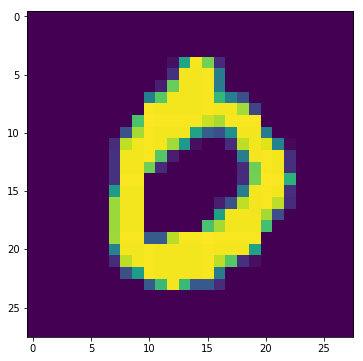

In [2]:
class_idx = 0
indices = np.where(y_test[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(x_test[idx][..., 0])

Time for saliency visualization.

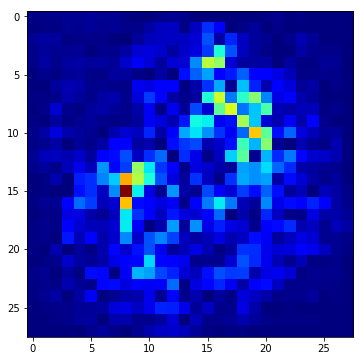

In [3]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

To used guided saliency, we need to set `backprop_modifier='guided'`. For rectified saliency or deconv saliency, use `backprop_modifier='relu'`. Lets try these options quickly and see how they compare to vanilla saliency.

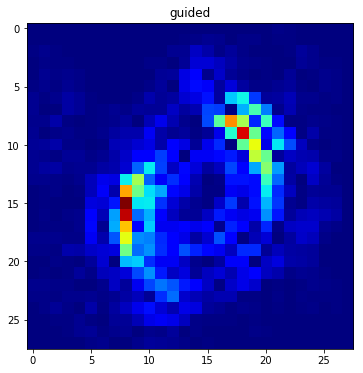

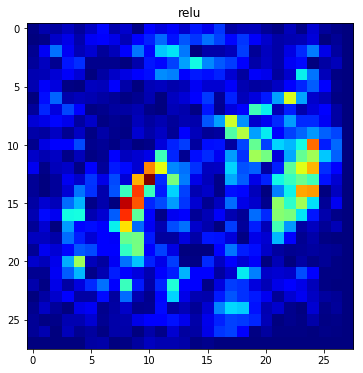

In [4]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

Both of them look a lot better than vanilla saliency! This in inline with observation in the paper.

We can also visualize negative gradients to see the parts of the image that contribute negatively to the output by using `grad_modifier='negate'`.

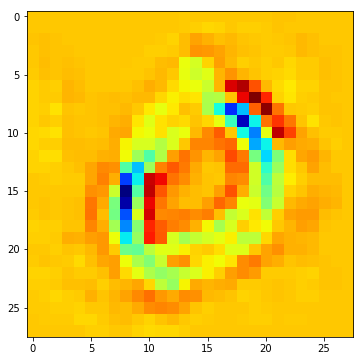

In [5]:
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx], 
                           backprop_modifier='guided', grad_modifier='negate')
plt.imshow(grads, cmap='jet')

Lets try all the classes and show original inputs and their heatmaps side by side. We cannot overlay the heatmap on original image since its grayscale.

We will also compare the outputs of guided and rectified or deconv saliency.

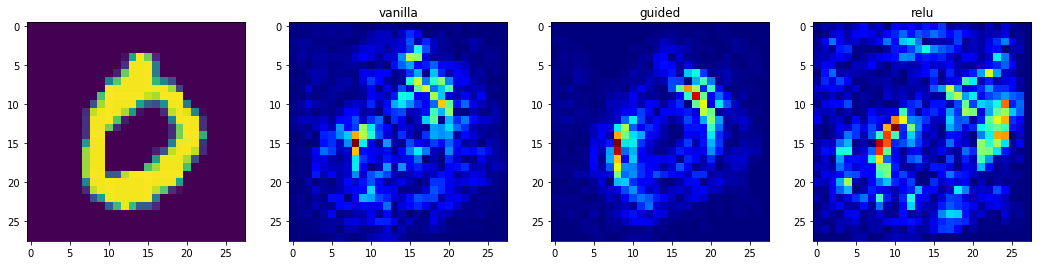

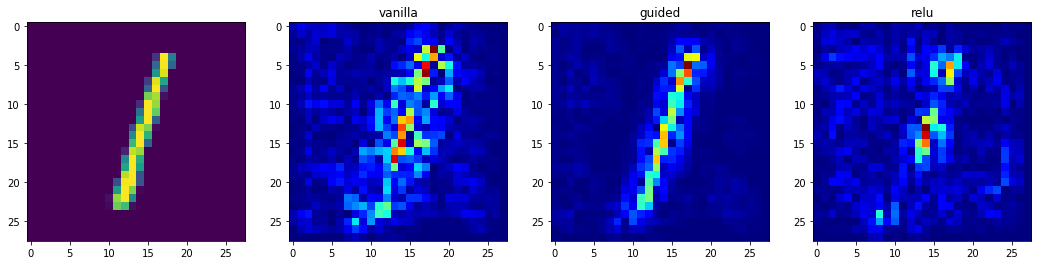

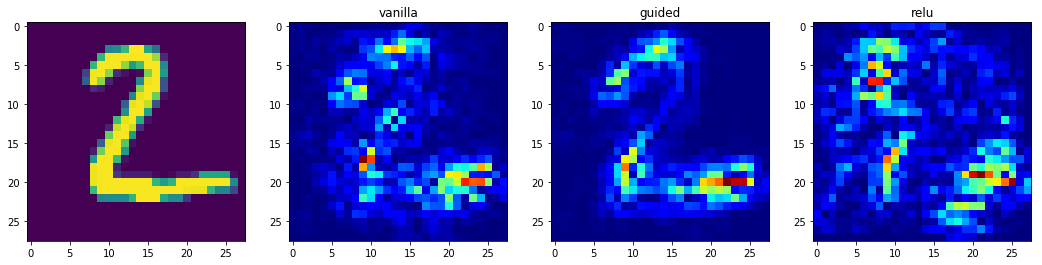

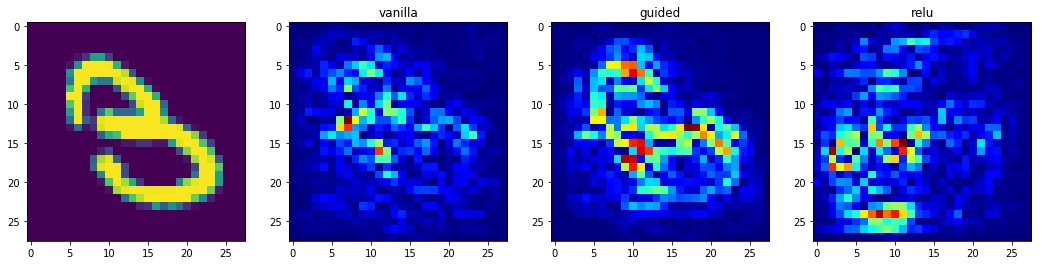

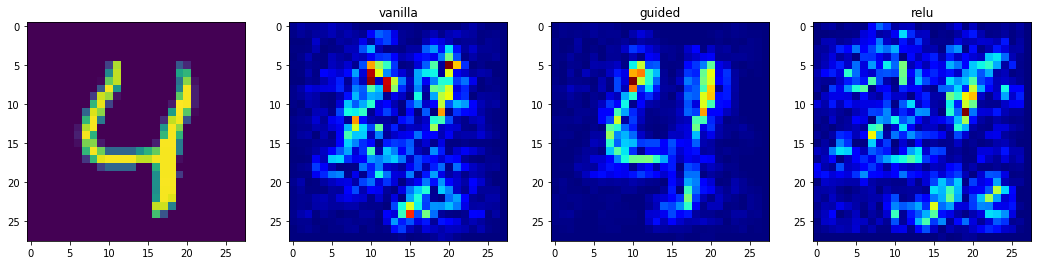

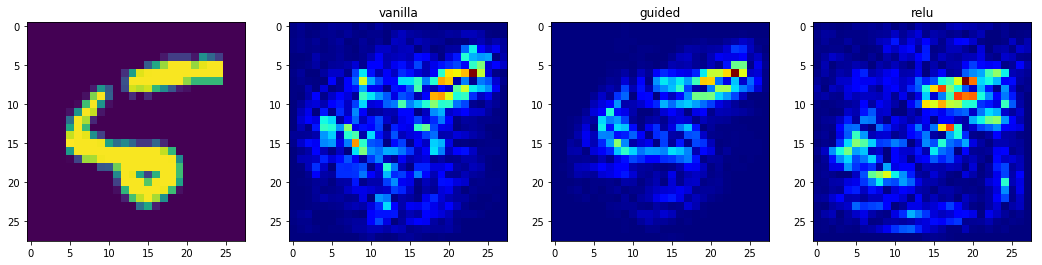

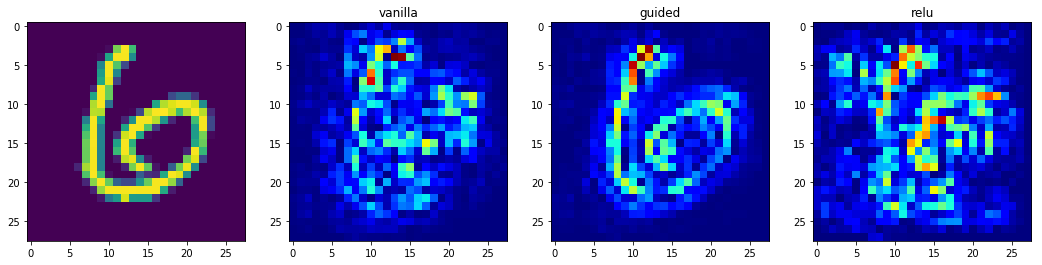

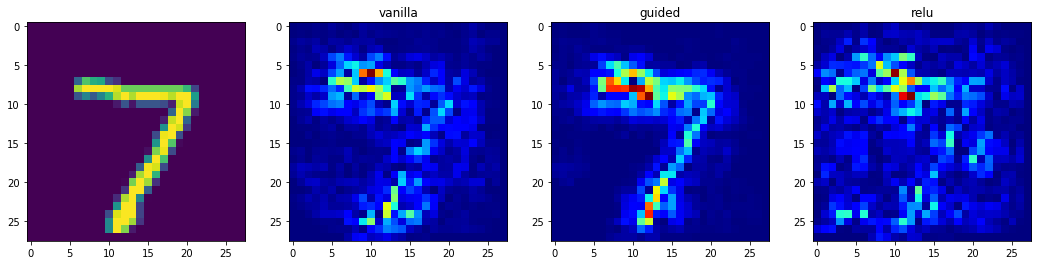

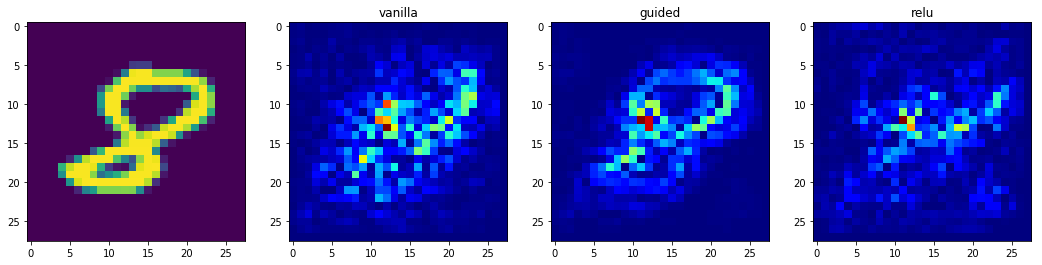

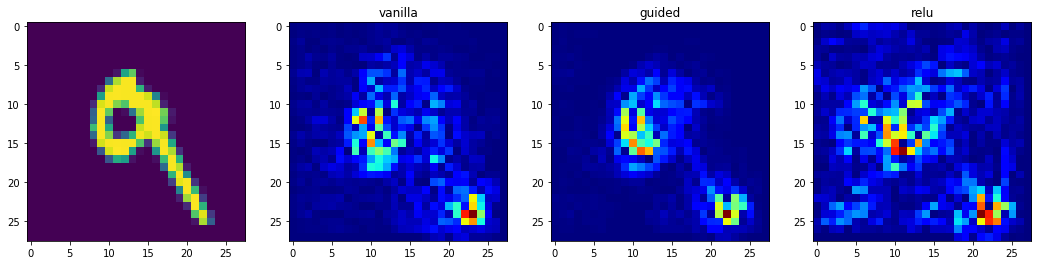

In [6]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=x_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

Guided saliency seems to give the best results.

## grad-CAM - vanilla, guided, rectified

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `MaxPooling2D` layer after all the `Conv` layers. Lets look at all the visualizations like before.

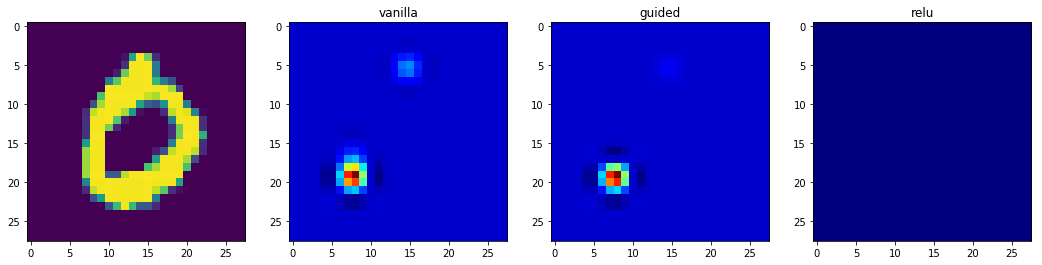

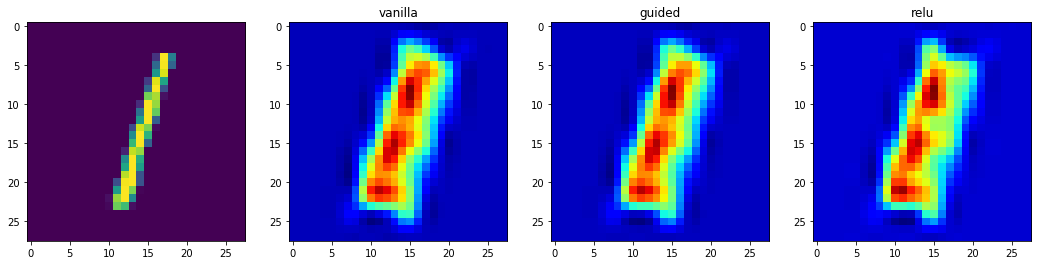

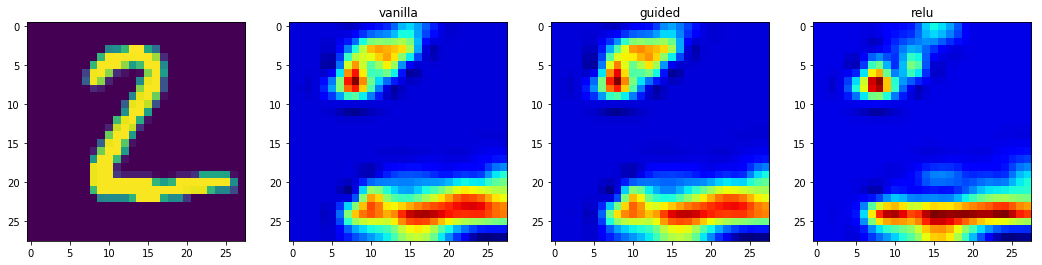

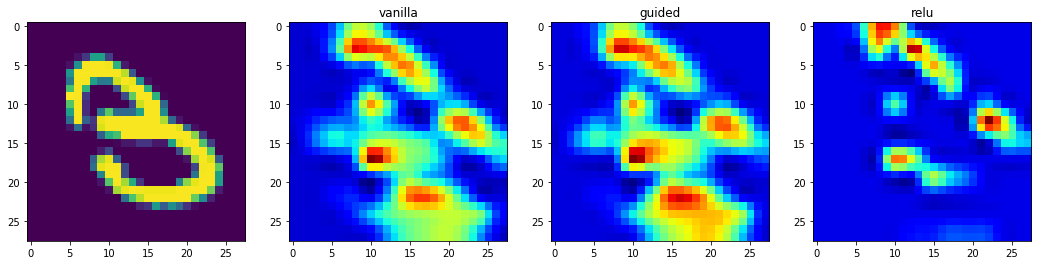

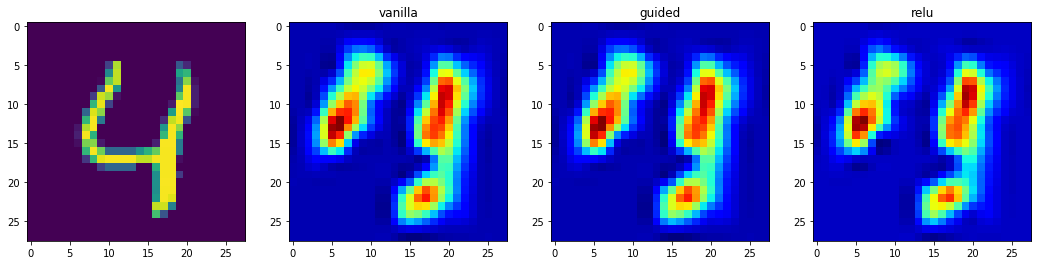

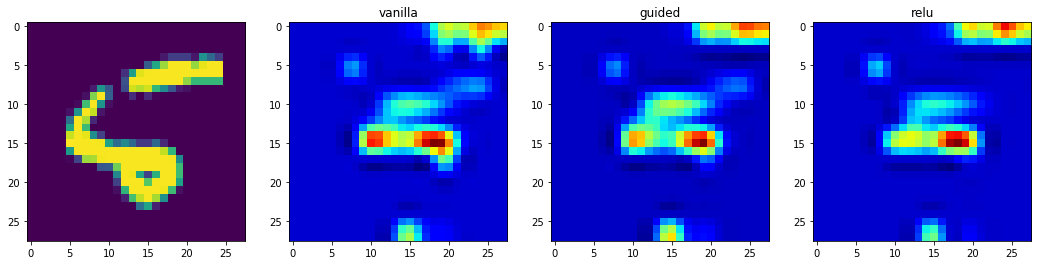

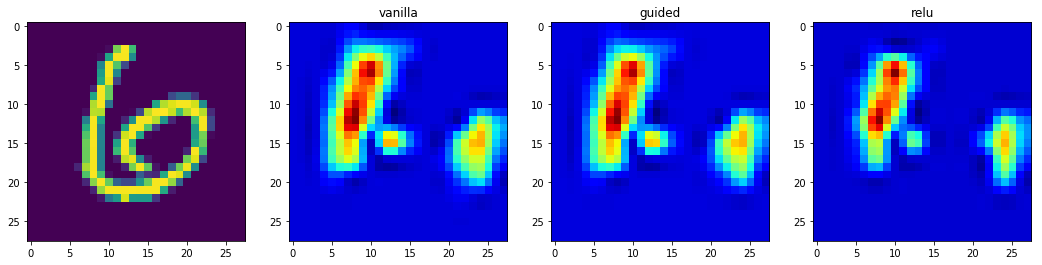

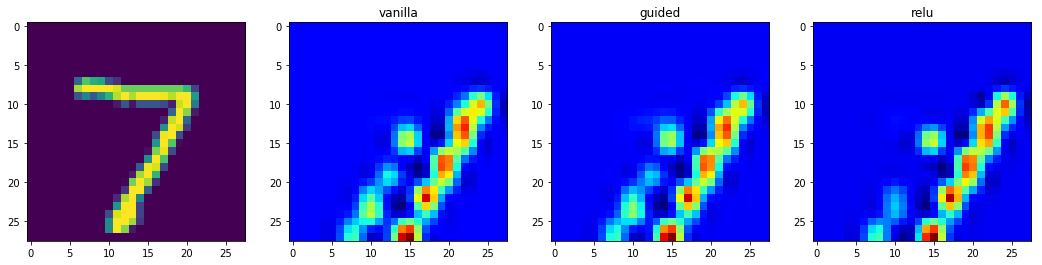

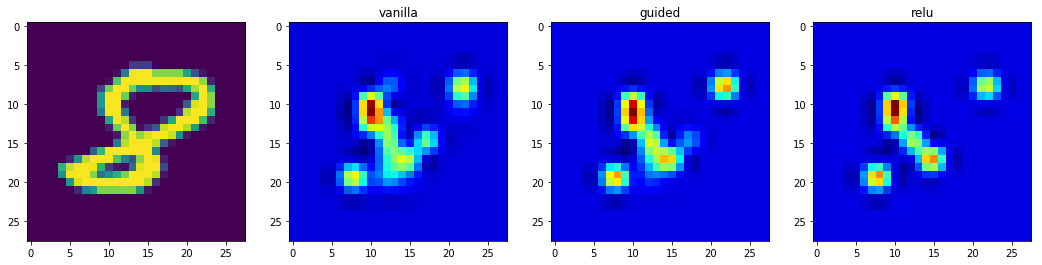

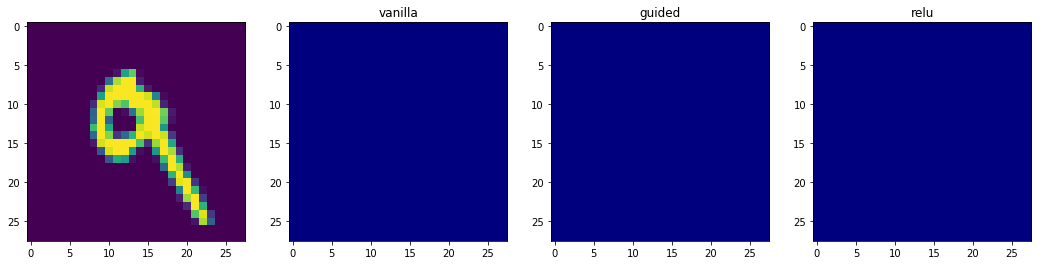

In [7]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_test[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

In this case it appears that saliency is better than grad-CAM as penultimate `MaxPooling2D` layer has `(12, 12)` spatial resolution which is relatively large as compared to input of `(28, 28)`. Is is likely that the conv layer hasnt captured enough high level information and most of that is likely within `dense_4` layer. 

Here is the model summary for reference.

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Visualization without swapping softmax

As alluded at the beginning of the tutorial, we want to compare and see what happens if we didnt swap out softmax for linear activation. Lets try this with guided saliency which gave us the best results so far.

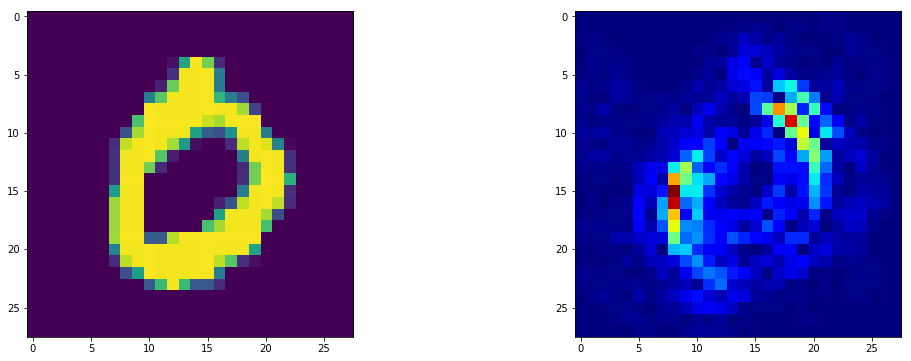

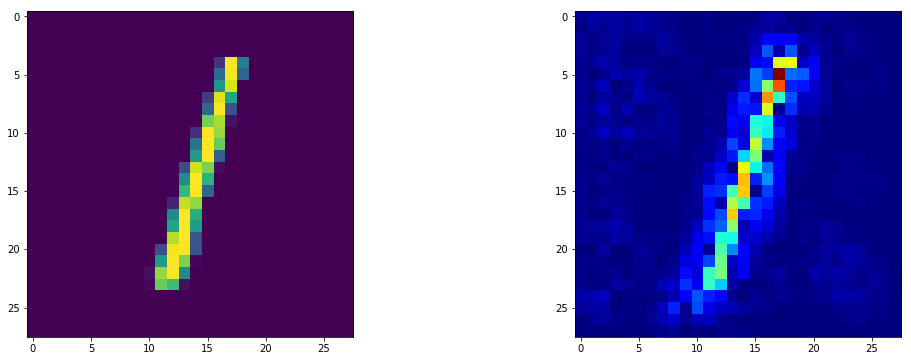

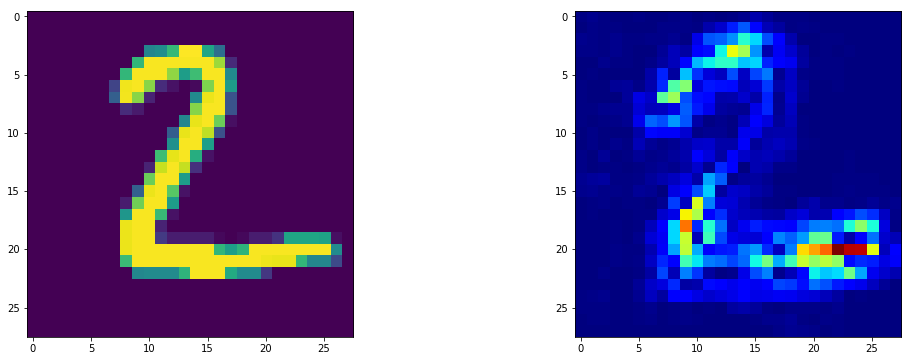

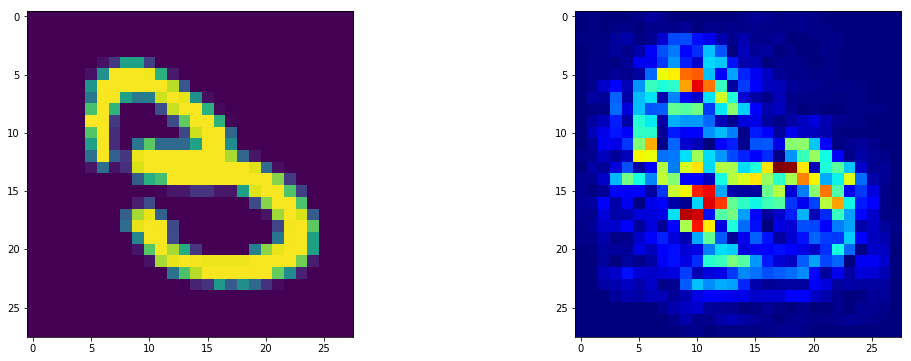

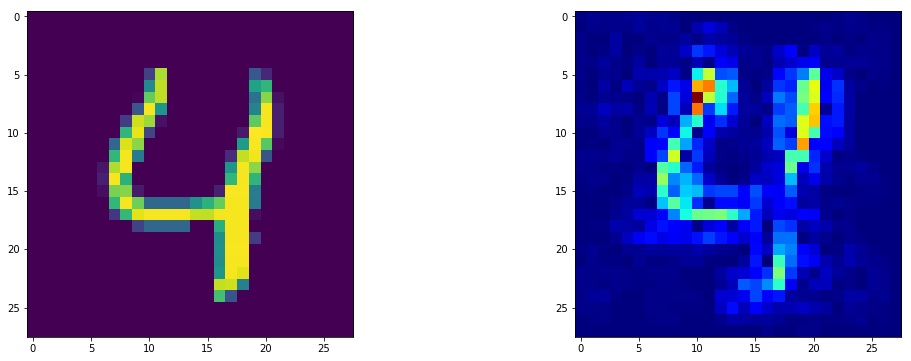

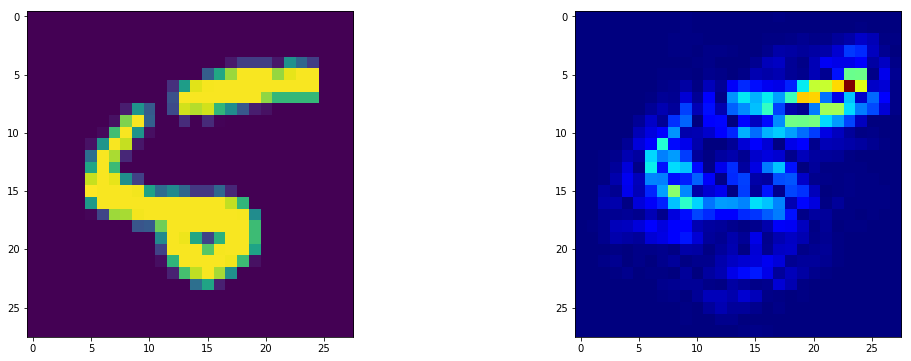

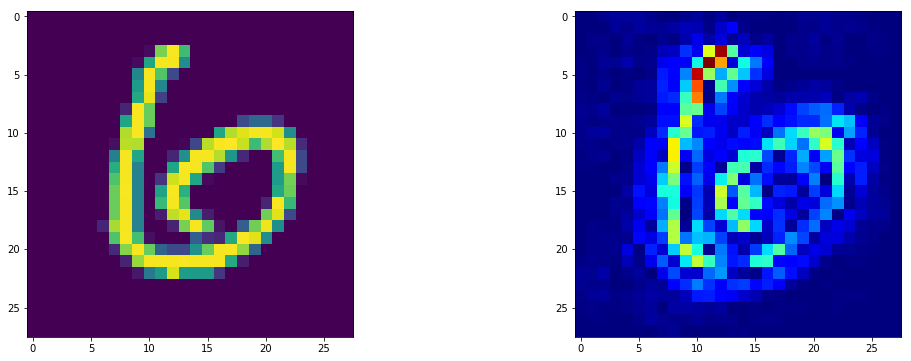

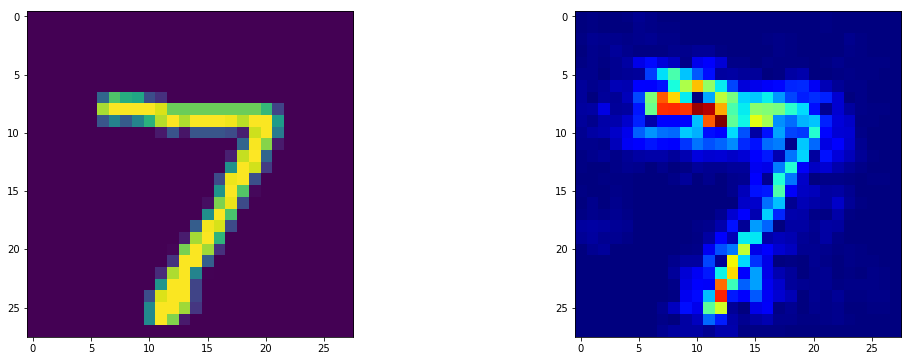

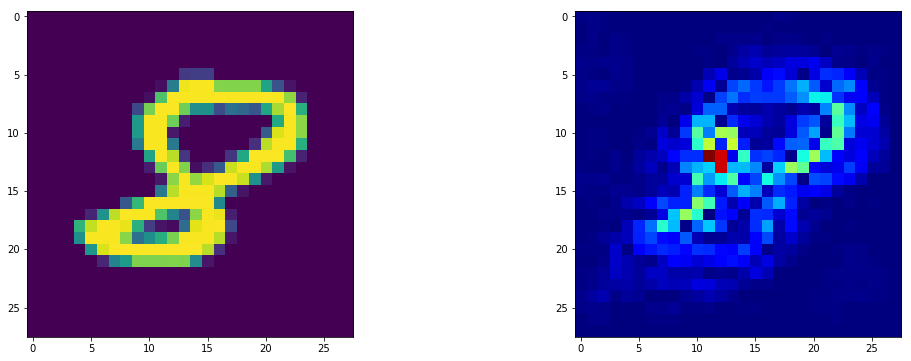

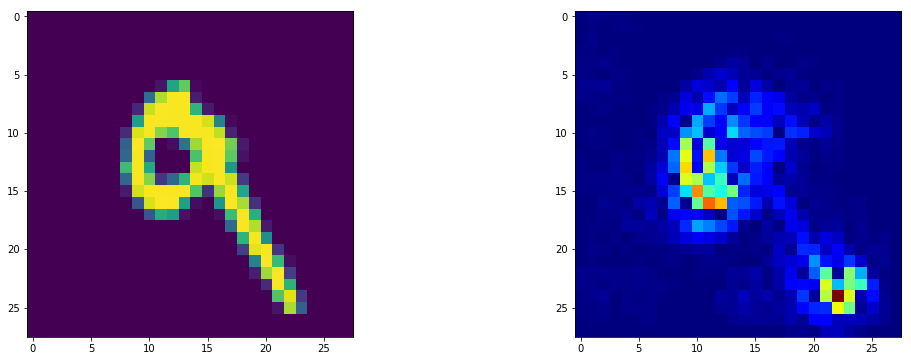

In [9]:
# Swap linear back with softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]
    
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                               seed_input=x_test[idx], backprop_modifier='guided')

    f, ax = plt.subplots(1, 2)
    ax[0].imshow(x_test[idx][..., 0])
    ax[1].imshow(grads, cmap='jet')

It does not work as well! 

It does not work! The reason is that maximizing an output node can be done by minimizing other outputs. Softmax is weird that way. It is the only activation that depends on other node output(s) in the layer.